In [272]:
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

# Get Order of MDSs

In [273]:
mdss = []; labels = []

# read the log and extract the order of the MDSs
with open("logs/greedy-spill.log") as f:
    for line in f:
        if "fsmap e" in line:
            del mdss[:]
            for w in line.split()[-1].split('='):
                if "mds-" in w:
                    mdss.append(w.strip("mds-"))
print mdss

# setup the MDS labels for graphing
for i in range(0, len(mdss)):
    labels.append("MDS" + str(i))


['issdm-12', 'issdm-15', 'issdm-18']


# Graph Helpers

In [277]:
# graph settings
PLT_ARGS = {'linewidth': 2.0}
PNG_ARGS = {'dpi': 300, 'bbox_inches': 'tight'}

# read in traces and find first timestamp
def read_traces(metric):
    PARSE_ARGS = {'engine': 'python', 'header': None, 'sep': (",|:"), 'names': ("seconds", metric), 'skiprows': 13}
    traces = {}
    min_ts = 1.7976931348623157e+308                           # max float
    
    for fname in glob.glob("utilization/" + metric + "-*.out"):# assumes you whisperdump'd to utilizations/metric-*.out
        try:                                                   # in case trace has no data
            traces[fname] = pd.read_table(fname, **PARSE_ARGS) # read with parser specified by PARSE_ARGS
            if traces[fname]['seconds'][0] < min_ts:           # find minimum timestamp
                min_ts = traces[fname]['seconds'][0]
        except:
            pass
    return traces, min_ts

# plot the metrics over time in MDS rank order
def plot_whisperdb(metric):
    traces, min_ts = read_traces(metric)
    ax = plt.figure().add_subplot(111)
    for mds in mdss:
        for fname in traces:
            if mds in fname:
                trace = traces[fname]
                trace = trace[trace.seconds != 0]               # ignore timestamps carbon did't get any metrics    
                ax.plot(trace['seconds'] - min_ts,              # slide x axis to start at 0
                        trace[metric],                          # plot the raw cpu 
                        label="MDS"+str(mdss.index(os.path.basename(fname).strip('.out').strip(metric+'-'))),         
                        **PLT_ARGS)
    ax.legend(loc='upper left')
    plt.savefig('greedy-spill-'+metric+'.png', **PNG_ARGS)

# Per-MDS CPU Utilization

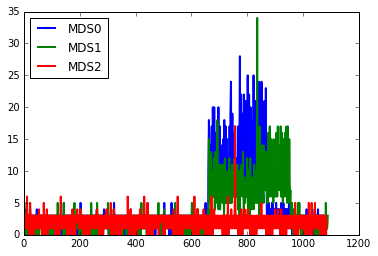

In [278]:
plot_whisperdb('cpu')

# Per-MDS Request Throughput

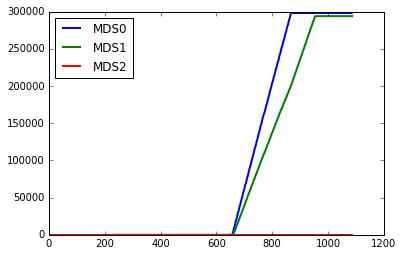

In [279]:
plot_whisperdb('reply')

# Per-MDS Load

In [280]:
# parse MDS0's log
df = pd.DataFrame(columns=tuple(mdss))
with open("logs/" + mdss[0] + "-daemon.log") as f:
    for line in f:
        if "load=" in line and "MDS" in line:
            words = line.split()
            for w in words:
                if "load=" in w:
                    if "MDS0" == words[words.index(w)-1]: 
                        temp = []
                    temp.append(w.split('=')[1])
                    if len(temp) >= len(mdss):
                        df.loc[len(df)] = temp

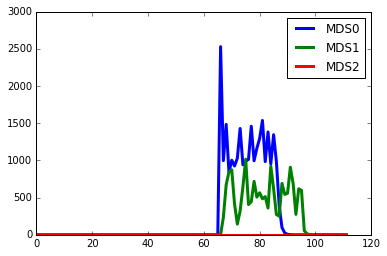

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df, linewidth=3.0)
ax.legend(labels)
plt.savefig('greedy-spill-load.png', dpi=300, bbox_inches='tight')